In [85]:
import numpy as np
import os
import pandas as pd
import sys
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import  Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import category_encoders as ce
import matplotlib.pyplot as plt
print(sys.version)
print(pd.__version__)

3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 21:15:04) 
[GCC 7.3.0]
1.1.5


In [96]:
agglo_hpis = ['n_clusters','affinity','linkage','compute_full_tree','imputation']
dbscan_hpis = ['eps','min_samples','metric','algorithm','leaf_size','imputation']
kmeans_hpis = ['n_clusters','init','max_iter','algorithm','n_init','tol']
meanshift_hpis = ['bin_seeding','cluster_all','max_iter','bandwidth','imputation']
optics_hpis = ['max_eps','eps','min_samples','cluster_method','xi','metric','algorithm','leaf_size','imputation']
spectralclustering_hpis = ['n_clusters','n_init','affinity','n_neighbors','assign_labels','imputation']

In [97]:
def read_dataset(model,hpis):
    path = "../performance_data/"+model+"_results.csv"
    df = pd.read_csv(path)
    X = df[hpis]
    y = df["silhouette_score"]
    return X, y

In [98]:
ml_model="spectralclustering"
ml_model_hpis = spectralclustering_hpis
X, y = read_dataset(ml_model,ml_model_hpis)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, random_state=42,
)

In [99]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [100]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names   
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        return X[self.feature_names] 

In [101]:
numeric_transformer = Pipeline(
    steps=[
    ("impute_median", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
                               ])
categorical_transformer = ce.OrdinalEncoder(handle_unknown="ignore")

In [102]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('cat_encoder', categorical_transformer, categorical_columns),
    ('num_encoder', numeric_transformer, numerical_columns)])

In [103]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
feat_name =  categorical_columns + numerical_columns

In [104]:
reg = RandomForestRegressor(random_state=1,n_jobs=-1)
reg.fit(X_train_transformed, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test_transformed))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0281


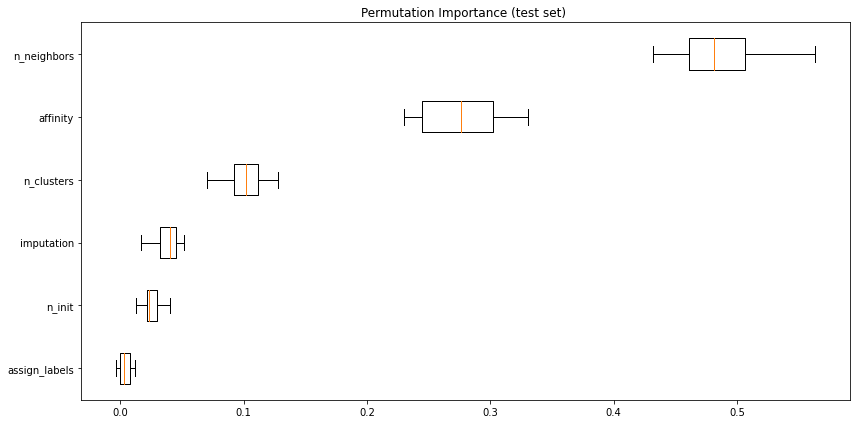

In [105]:
fig = plt.figure(figsize=(12, 6))

result = permutation_importance(reg, X_test_transformed, y_test, n_repeats=10, random_state=42, n_jobs=-1,)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_name)[sorted_idx],
)
plt.title("Permutation Importance (test set) ")
fig.tight_layout()
plt.savefig(f'../output_plots/permutation_importance/{ml_model}_importance.pdf')  
plt.show()